In [5]:
import kagglehub
sciencelabwork_hyperspectral_image_sensing_dataset_ground_truth_path = kagglehub.dataset_download('sciencelabwork/hyperspectral-image-sensing-dataset-ground-truth')
print('Data source import complete.')

Data source import complete.


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_corrected.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC_gt.mat


In [3]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [7]:
!pip install ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 6.5 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=de24695cce63b3033f4c0c15ca36fab220e9c48ba38e1d7cc31601220f5ff32e
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [ ]:
!pip install tensorflow

In [8]:
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import scipy.ndimage as nd
import numpy as np
from ripser import ripser
from scipy.stats import entropy
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, f1_score, jaccard_score
import time
from sklearn.preprocessing import MinMaxScaler


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Paths
DATA_PATH = "/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/best_topomorph.h5"

# ksh

In [15]:
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score, jaccard_score
from keras.models import load_model
from keras.utils import to_categorical
from skimage.morphology import disk
from skimage.filters.rank import entropy
import cv2
import tensorflow as tf

# === PATHS ===
#DATA_PATH = "/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/"
#MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_models/best_topomorph.keras"

# === PARAMETERS ===
PATCH_SIZE = 13
TOP_K = 30  # number of bands to select

# === LOAD KSC DATA ===
data = sio.loadmat(DATA_PATH + "KSC.mat")['KSC']
gt = sio.loadmat(DATA_PATH + "KSC_gt.mat")['KSC_gt']
print("KSC shape:", data.shape, "GT shape:", gt.shape)  # (512, 614, 176)

# === MORPHOLOGICAL BAND SELECTION (MBSA) ===
def compute_mbsa(data):
    h, w, c = data.shape
    saliencies = []
    for i in range(c):
        band = data[:, :, i]
        norm_band = cv2.normalize(band, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        entropy_img = entropy(norm_band, disk(5))
        saliency = np.mean(entropy_img)
        saliencies.append(saliency)
    return np.argsort(saliencies)[-TOP_K:]  # Top-K saliency bands

# === SELECT BANDS ===
selected_band_indices = compute_mbsa(data)
print("Selected band indices (MBSA):", selected_band_indices)

data = data[:, :, selected_band_indices]
h, w, c = data.shape

# === NORMALIZATION ===
data_reshaped = data.reshape(-1, c)
data_scaled = MinMaxScaler().fit_transform(data_reshaped).reshape(h, w, c)

# === PADDING ===
pad = PATCH_SIZE // 2
data_padded = np.pad(data_scaled, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

# === PATCH EXTRACTION ===
X_patches, y_labels = [], []
for i in range(h):
    for j in range(w):
        label = gt[i, j]
        if label == 0:
            continue
        patch = data_padded[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
        X_patches.append(patch)
        y_labels.append(label - 1)  # zero-indexed

X_patches = np.array(X_patches)
y_labels = np.array(y_labels)
print("Extracted patches:", X_patches.shape)


KSC shape: (512, 614, 176) GT shape: (512, 614)
Selected band indices (MBSA): [62 71 63 36 65 67 66 76 37 58 55 54 57 39 38 53 40 51 52 56 41 50 46 47
 49 48 42 45 43 44]
Extracted patches: (5211, 13, 13, 30)


In [16]:
# === TOPO FEATURES PLACEHOLDER ===
topo_features = np.ones((X_patches.shape[0], 1))  # replace with real topo features if needed

In [17]:
# === LOAD TRAINED MODEL ===
model = load_model(MODEL_PATH)

In [18]:
# === EVALUATE ===
y_true = y_labels
y_true_cat = to_categorical(y_true, num_classes=14)

In [19]:
from tensorflow.keras.utils import to_categorical

# KSC original labels start from 1, so subtract 1 to make it 0-indexed
y_true = y_labels-1

# One-hot encode into 16 classes (not 14)
y_true_cat = to_categorical(y_labels, num_classes=16)

In [ ]:
np.unique(y_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Convert to one-hot (pad to 16 classes)
y_true_cat = to_categorical(y_labels, num_classes=16)

# 2. Load model
model = load_model(MODEL_PATH,
                   compile=False)

# 3. Compile the model for fine-tuning
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Split into train-val
X_img_train, X_img_val, X_topo_train, X_topo_val, y_train, y_val = train_test_split(
    X_patches, topo_features, y_true_cat, test_size=0.2, random_state=42, stratify=y_labels)

# 5. Fine-tune the model on KSC
history = model.fit(
    [X_img_train, X_topo_train],
    y_train,
    validation_data=([X_img_val, X_topo_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# 6. Evaluate
resP = model.evaluate([X_img_val, X_topo_val], y_val)
print("Loss:", resP[0])
print("Accuracy:", resP[1])


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1450 - loss: 2.6644 - val_accuracy: 0.1831 - val_loss: 2.2863
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3314 - loss: 2.0548 - val_accuracy: 0.5005 - val_loss: 1.4613
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5884 - loss: 1.2877 - val_accuracy: 0.7172 - val_loss: 0.9543
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7193 - loss: 0.8856 - val_accuracy: 0.7776 - val_loss: 0.6838
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8243 - loss: 0.5618 - val_accuracy: 0.8303 - val_loss: 0.4682
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8499 - loss: 0.4342 - val_accuracy: 0.8380 - val_loss: 0.3842
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8735 - loss: 0.3536 - val_accuracy: 0.8897 - val_loss: 0.3173
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8971 - loss: 0.2826 - val_accuracy

OA = (Number of correctly classified samples)/ (Total number of test samples)
= validation accuracy

Add Label Smoothing:

Add Dropout (0.3~0.5) before dense layers.

Add learning rate scheduler:

for improve


In [22]:
X_test_patch = X_patches
X_test_topo = topo_features

In [23]:
results = {}  # to store metrics for all models

In [24]:
y_true = np.argmax(y_true_cat, axis=1)
y_pred_probs = model.predict([X_test_patch, X_test_topo], verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


🎯 Average Accuracy (AA): 0.9967
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ Overall Accuracy (OA): 0.9979
🧮 Cohen’s Kappa: 0.9976

📊 Confusion Matrix:
 [[761   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 243   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2 251   1   0   2   0   0   0   0   0   0   0]
 [  0   0   1 249   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0 161   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0 226   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 105   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 431   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 520   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 404   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 419   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 503   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 927]]

🔎 Classification Report:
              precision    recall  f1-score   support

           0     0.9961    1.0000    0.9980       76

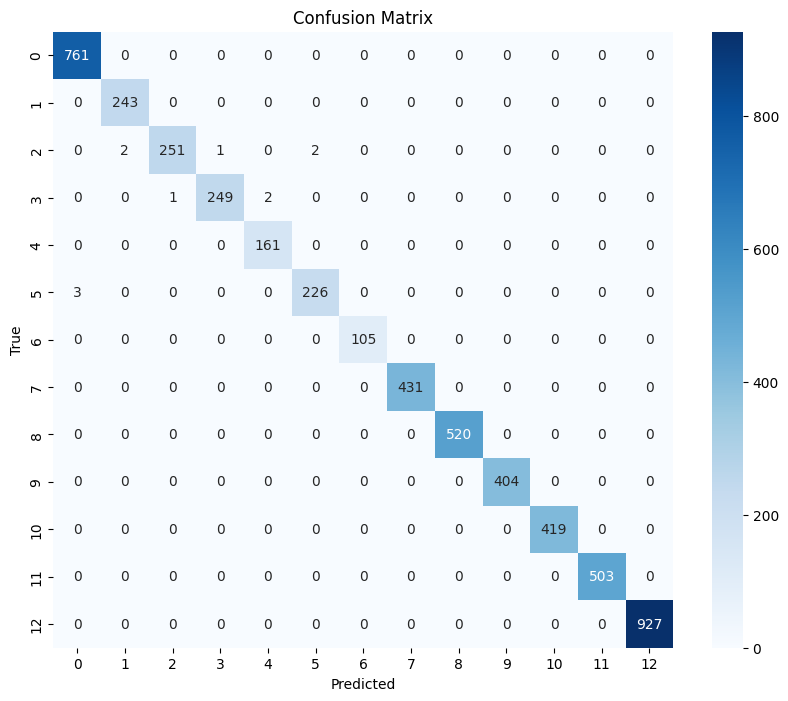

In [25]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, cohen_kappa_score,
    f1_score, precision_score, recall_score,
    jaccard_score
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get only the actual present class labels
present_classes = sorted(set(y_true) | set(y_pred))  # union of both sets
report = classification_report(y_true, y_pred, output_dict=True)
cls_f1 = [report[str(i)]['f1-score'] for i in present_classes]
aa = np.mean(cls_f1)

print("🎯 Average Accuracy (AA):", round(aa, 4))

# y_true: true labels (1D array), y_pred: predicted labels (1D array)
y_true = np.argmax(y_true_cat, axis=1)
y_pred_probs = model.predict([X_test_patch, X_test_topo], verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

oa = accuracy_score(y_true, y_pred)
print("✅ Overall Accuracy (OA):", round(oa, 4))

kappa = cohen_kappa_score(y_true, y_pred)
print("🧮 Cohen’s Kappa:", round(kappa, 4))

cm = confusion_matrix(y_true, y_pred)
print("\n📊 Confusion Matrix:\n", cm)

print("\n🔎 Classification Report:")
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
print(classification_report(y_true, y_pred, digits=4))

# Class-wise IoU (Jaccard Index)
iou = jaccard_score(y_true, y_pred, average=None)
for i, score in enumerate(iou):
    print(f"Class {i} IoU: {score:.4f}")
print("📌 Mean IoU (mIoU):", round(np.mean(iou), 4))

# Optional: Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
from sklearn.metrics import classification_report

# Get the classification report as a dictionary
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Prepare containers
num_classes = 13
cls_f1 = []
cls_precision = []
cls_recall = []

for i in range(num_classes):
    class_str = str(i)
    if class_str in report:
        cls_f1.append(round(report[class_str]['f1-score'], 4))
        cls_precision.append(round(report[class_str]['precision'], 4))
        cls_recall.append(round(report[class_str]['recall'], 4))
    else:
        cls_f1.append(0.0)
        cls_precision.append(0.0)
        cls_recall.append(0.0)

# Average Accuracy
aa = round(np.mean(cls_f1), 4)

# OA and Kappa (already computed before)
# oa = accuracy_score(y_true, y_pred)
# kappa = cohen_kappa_score(y_true, y_pred)

# Store all in results
results['Proposed Model'] = {
    'OA': round(oa, 4),
    'AA': aa,
    'Kappa': round(kappa, 4),
    'F1': cls_f1,
    'Precision': cls_precision,
    'Recall': cls_recall
}

In [ ]:
results

{'Proposed Model': {'OA': 1.0,
  'AA': np.float64(1.0),
  'Kappa': np.float64(1.0),
  'F1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'Precision': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'Recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}}

In [27]:
proposed=model

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, LSTM
import numpy as np

# Labels: zero-indexed
y_labels = np.array(y_labels)
y_true = y_labels - 1  # or just use y_labels if already zero-indexed
# One-hot encoding
num_classes = len(np.unique(y_labels))
y_true_cat = to_categorical(y_labels, num_classes=num_classes)

In [29]:
# ML models
X_flat = X_patches.reshape(X_patches.shape[0], -1)

# CNN/RNN
X_seq = X_patches.reshape(X_patches.shape[0], -1, X_patches.shape[-1])  # (N, 169, 30)
X_patch = X_patches  # (N, 13, 13, 30)

# Split once and reuse
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y_labels, test_size=0.2, stratify=y_labels, random_state=42)
X_train_patch, X_test_patch, _, _ = train_test_split(X_patch, y_labels, test_size=0.2, stratify=y_labels, random_state=42)
X_train_seq, X_test_seq, _, _ = train_test_split(X_seq, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

In [30]:
svm = SVC(kernel='rbf', C=10)
svm.fit(X_train_flat, y_train)
y_pred_svm = svm.predict(X_test_flat)

In [31]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)

In [32]:
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_patch.shape[1:]),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_patch, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
y_pred_cnn = np.argmax(cnn.predict(X_test_patch), axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [33]:
def build_cnn_encoder(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

cnn_encoder = build_cnn_encoder(X_train_patch.shape[1:], num_classes)
cnn_encoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_encoder.fit(X_train_patch, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
y_pred_encoder = np.argmax(cnn_encoder.predict(X_test_patch), axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [34]:
rnn = Sequential([
    LSTM(64, input_shape=X_train_seq.shape[1:]),
    Dense(num_classes, activation='softmax')
])
rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
y_pred_rnn = np.argmax(rnn.predict(X_test_seq), axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
results

{'Proposed Model': {'OA': 1.0,
  'AA': np.float64(1.0),
  'Kappa': np.float64(1.0),
  'F1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'Precision': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'Recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}}

In [35]:
def evaluate_model(name, y_true, y_pred):
    from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score

    report = classification_report(y_true, y_pred, output_dict=True, digits=4)
    oa = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    aa = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_scores = [report[str(i)]['f1-score'] for i in range(num_classes)]

    results[name] = {
        "OA": oa,
        "AA": aa,
        "Kappa": kappa,
        "F1": f1_scores
    }

    print(f"📌 {name} Results")
    print("✅ OA:", round(oa, 4), " | 🟩 AA:", round(aa, 4), " | 📊 Kappa:", round(kappa, 4))
    print("🎯 F1/class:", np.round(f1_scores, 4))
    print("-" * 50)

In [36]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Add
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, GlobalAveragePooling2D, Dense, Reshape, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization, Dropout, Add, Concatenate
)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])

    # Feed Forward
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation='relu')(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([x, y])

def build_gtfn(input_shape=(13, 13, 30), num_classes=14):
    inputs = Input(shape=input_shape)

    # CNN Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    cnn_feat = GlobalAveragePooling2D()(x)

    # Transformer Branch
    patch_h, patch_w, channels = x.shape[1], x.shape[2], x.shape[3]
    seq = Reshape((patch_h * patch_w, channels))(x)  # (None, 169, 64)
    x_trans = transformer_encoder(seq, head_size=64, num_heads=4, ff_dim=128)
    trans_feat = GlobalAveragePooling1D()(x_trans)

    # Fusion
    fused = Concatenate()([cnn_feat, trans_feat])
    outputs = Dense(num_classes, activation='softmax')(fused)

    return Model(inputs, outputs)

In [37]:
gtfn_model = build_gtfn(input_shape=X_train_patch.shape[1:], num_classes=num_classes)
gtfn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gtfn_model.fit(X_train_patch, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
y_pred_gtfn = np.argmax(gtfn_model.predict(X_test_patch), axis=1)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.3773 - loss: 1.9213 - val_accuracy: 0.6739 - val_loss: 0.9762
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7042 - loss: 0.8144 - val_accuracy: 0.8010 - val_loss: 0.6034
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8055 - loss: 0.5511 - val_accuracy: 0.7410 - val_loss: 0.7459
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8353 - loss: 0.4752 - val_accuracy: 0.8513 - val_loss: 0.4653
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8444 - loss: 0.4362 - val_accuracy: 0.9113 - val_loss: 0.2859
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8794 - loss: 0.3357 - val_accuracy: 0.7794 - val_loss: 0.9600
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8357 - loss: 0.4708 - val_accuracy: 0.8585 - val_loss: 0.3848
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8959 - loss: 0.3111 - val_accuracy: 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


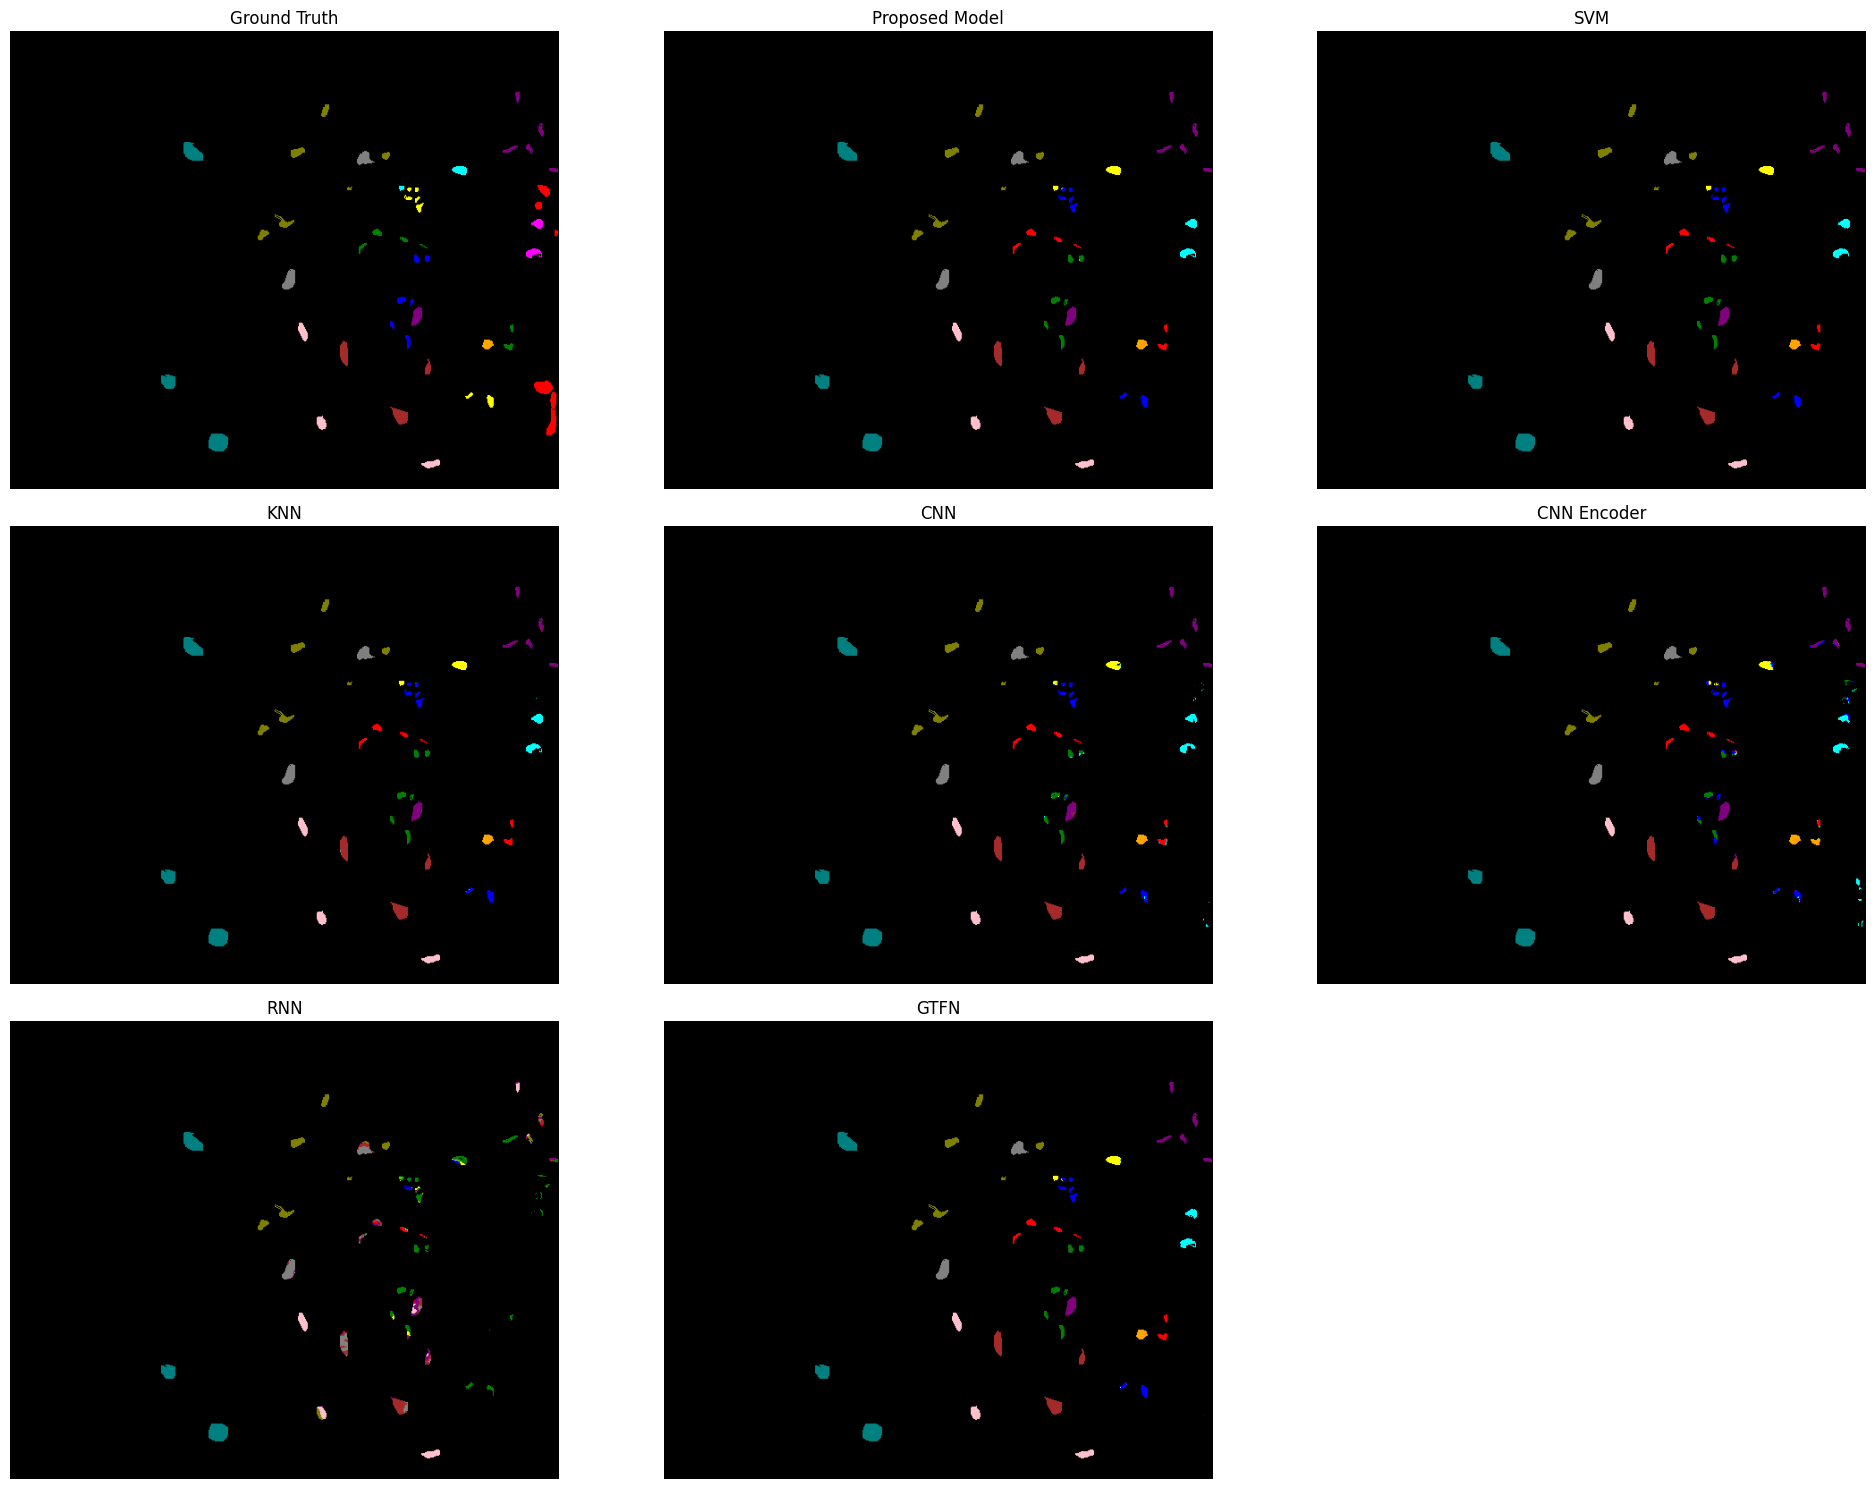

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a function to generate prediction maps
def create_prediction_map(model, X_data, original_gt_shape, model_type='proposed'):
    if model_type in ['svm', 'knn']:
        # For flat models (SVM, KNN)
        X_flat = X_data.reshape(X_data.shape[0], -1)
        pred_flat = model.predict(X_flat)
        pred_map = np.zeros(original_gt_shape)
    elif model_type in ['cnn', 'cnn_encoder', 'gtfn']:
        # For CNN-based models
        pred_patch = np.argmax(model.predict(X_data), axis=1)
        pred_map = np.zeros(original_gt_shape)
    elif model_type == 'rnn':
        # For RNN model
        X_seq = X_data.reshape(X_data.shape[0], -1, X_data.shape[-1])
        pred_seq = np.argmax(model.predict(X_seq), axis=1)
        pred_map = np.zeros(original_gt_shape)
    else:  # proposed model
        pred_probs = model.predict([X_data, np.ones((X_data.shape[0], 1))])
        pred_patch = np.argmax(pred_probs, axis=1)
        pred_map = np.zeros(original_gt_shape)

    # Fill the prediction map
    idx = 0
    for i in range(original_gt_shape[0]):
        for j in range(original_gt_shape[1]):
            if gt[i, j] != 0:
                if model_type in ['svm', 'knn']:
                    pred_map[i, j] = pred_flat[idx]
                elif model_type in ['cnn', 'cnn_encoder', 'gtfn', 'proposed']:
                    pred_map[i, j] = pred_patch[idx]
                elif model_type == 'rnn':
                    pred_map[i, j] = pred_seq[idx]
                idx += 1
    return pred_map

# Original data shapes
original_shape = gt.shape
h, w = original_shape

# Create ground truth map (already have gt)
gt_map = gt.copy()

# Create prediction maps for all models
proposed_map = create_prediction_map(proposed, X_patches, original_shape, 'proposed')
svm_map = create_prediction_map(svm, X_patches, original_shape, 'svm')
knn_map = create_prediction_map(knn, X_patches, original_shape, 'knn')
cnn_map = create_prediction_map(cnn, X_patches, original_shape, 'cnn')
cnn_encoder_map = create_prediction_map(cnn_encoder, X_patches, original_shape, 'cnn_encoder')
rnn_map = create_prediction_map(rnn, X_patches, original_shape, 'rnn')
gtfn_map = create_prediction_map(gtfn_model, X_patches, original_shape, 'gtfn')

# Define a colormap (adjust colors as needed)
colors = [
    'black', 'red', 'green', 'blue', 'yellow',
    'cyan', 'magenta', 'orange', 'purple', 'brown',
    'pink', 'gray', 'olive', 'teal'
]
cmap = ListedColormap(colors[:len(np.unique(gt_map))])

# Plot all maps
plt.figure(figsize=(20, 15))

plt.subplot(3, 3, 1)
plt.imshow(gt_map, cmap=cmap)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(proposed_map, cmap=cmap)
plt.title('Proposed Model')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(svm_map, cmap=cmap)
plt.title('SVM')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(knn_map, cmap=cmap)
plt.title('KNN')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(cnn_map, cmap=cmap)
plt.title('CNN')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(cnn_encoder_map, cmap=cmap)
plt.title('CNN Encoder')
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(rnn_map, cmap=cmap)
plt.title('RNN')
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(gtfn_map, cmap=cmap)
plt.title('GTFN')
plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
def evaluate_model(name, y_true, y_pred, num_classes, results_dict):
    from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True, digits=4, zero_division=0)

    oa = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    # Compute per-class metrics safely
    recalls = []
    f1_scores = []
    precisions = []

    for i in range(num_classes):
        label = str(i)
        if label in report:
            recalls.append(report[label]['recall'])
            f1_scores.append(report[label]['f1-score'])
            precisions.append(report[label]['precision'])
        else:
            recalls.append(0.0)
            f1_scores.append(0.0)
            precisions.append(0.0)

    aa = np.mean(recalls)

    # Store results
    results_dict[name] = {
        "OA": oa,
        "AA": aa,
        "Kappa": kappa,
        "F1": f1_scores,
        "Precision": precisions,
        "Recall": recalls,
    }

    # Print summary
    print(f"📌 {name} Results")
    print("✅ OA:", round(oa, 4), " | 🟩 AA:", round(aa, 4), " | 📊 Kappa:", round(kappa, 4))
    print("🎯 F1/class:", np.round(f1_scores, 4))
    print("🎯 Precision/class:", np.round(precisions, 4))
    print("🎯 Recall/class:", np.round(recalls, 4))
    print("-" * 60)


In [ ]:
#results = {}
evaluate_model("SVM", y_test, y_pred_svm, num_classes, results)
evaluate_model("KNN", y_test, y_pred_knn, num_classes, results)
evaluate_model("CNN", y_test, y_pred_cnn, num_classes, results)
evaluate_model("Encoder", y_test, y_pred_encoder, num_classes, results)
evaluate_model("RNN", y_test, y_pred_rnn, num_classes, results)

📌 SVM Results
✅ OA: 0.9942  | 🟩 AA: 0.99  | 📊 Kappa: 0.9936
🎯 F1/class: [0.9806 1.     1.     1.     1.     0.9302 1.     1.     1.     1.
 1.     1.     1.    ]
🎯 Precision/class: [0.962 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.   ]
🎯 Recall/class: [1.     1.     1.     1.     1.     0.8696 1.     1.     1.     1.
 1.     1.     1.    ]
------------------------------------------------------------
📌 KNN Results
✅ OA: 0.9741  | 🟩 AA: 0.9628  | 📊 Kappa: 0.9711
🎯 F1/class: [0.959  0.9684 0.9808 0.9362 0.9846 0.878  1.     0.9762 0.9524 1.
 0.9711 1.     1.    ]
🎯 Precision/class: [0.9212 1.     0.9623 1.     0.9697 1.     1.     1.     0.9434 1.
 0.9438 1.     1.    ]
🎯 Recall/class: [1.     0.9388 1.     0.88   1.     0.7826 1.     0.9535 0.9615 1.
 1.     1.     1.    ]
------------------------------------------------------------
📌 CNN Results
✅ OA: 0.9559  | 🟩 AA: 0.9407  | 📊 Kappa: 0.9509
🎯 F1/class: [0.915  0.9897 0.8542 0.8958 0.8533 0.6889 1.     0.9942 0.9

In [ ]:
train_ratios = [ 0.3, 0.5, 0.7, 0.8, 0.9]  # Training split percentages
model_names = ['SVM', 'KNN', 'CNN', 'Encoder', 'RNN', 'GTFN','Proposed']
metrics = ['OA', 'AA', 'Kappa']

In [ ]:
from collections import defaultdict
results_by_ratio = {model: defaultdict(list) for model in model_names}

In [ ]:
results

{'Proposed Model': {'OA': 0.9996,
  'AA': np.float64(0.9994),
  'Kappa': np.float64(0.9996),
  'F1': [1.0, 1.0, 0.9961, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'Precision': [1.0,
   1.0,
   0.9961,
   0.996,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'Recall': [1.0,
   1.0,
   0.9961,
   0.996,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0]},
 'SVM': {'OA': 0.9942473633748802,
  'AA': np.float64(0.9899665551839465),
  'Kappa': np.float64(0.9935907414993855),
  'F1': [0.9806451612903225,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9302325581395349,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'Precision': [0.9620253164556962,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'Recall': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.8695652173913043,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0]},
 'KNN': {'OA': 0.9741131351869607,
  'AA': np.float64(0.9628

In [ ]:
def evaluate_model_byratio(model_name, y_true, y_pred, num_classes, results_dict):
    oa = accuracy_score(y_true, y_pred)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    aa = np.mean(recall_per_class)

    results_dict[model_name]['OA'].append(oa)
    results_dict[model_name]['AA'].append(aa)
    results_dict[model_name]['Kappa'].append(kappa)


In [ ]:
for ratio in train_ratios:
    print(f"\n📌 Proposed Model — Training Ratio: {int(ratio * 100)}%")

    # Prepare stratified train-test split
    y_true_cat = to_categorical(y_labels, num_classes=16)
    X_img_train, X_img_test, X_topo_train, X_topo_test, y_train, y_test = train_test_split(
        X_patches, topo_features, y_true_cat, train_size=ratio, random_state=42, stratify=y_labels
    )

    # Reload fresh model (to avoid weight carryover)
    model = load_model(MODEL_PATH, compile=False)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    model.fit(
        [X_img_train, X_topo_train],
        y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
    )

    # Predict
    y_pred = np.argmax(model.predict([X_img_test, X_topo_test]), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Evaluate
    evaluate_model_byratio("Proposed", y_true, y_pred, num_classes, results_by_ratio)


📌 Proposed Model — Training Ratio: 30%
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📌 Proposed Model — Training Ratio: 50%
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

📌 Proposed Model — Training Ratio: 70%
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

📌 Proposed Model — Training Ratio: 80%
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

📌 Proposed Model — Training Ratio: 90%
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from tensorflow.keras.utils import to_categorical
from collections import defaultdict

# Initialize result storage: results_by_ratio[model][metric] = list of values

for ratio in train_ratios:
    print(f"\n🔁 Training ratio: {int(ratio*100)}%")

    # Split
    X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y_labels, train_size=ratio, stratify=y_labels, random_state=42)
    X_train_patch, X_test_patch, _, _ = train_test_split(X_patch, y_labels, train_size=ratio, stratify=y_labels, random_state=42)
    X_train_seq, X_test_seq, _, _ = train_test_split(X_seq, y_labels, train_size=ratio, stratify=y_labels, random_state=42)

    # --- SVM ---
    svm.fit(X_train_flat, y_train)
    y_pred = svm.predict(X_test_flat)
    evaluate_model_byratio("SVM", y_test, y_pred, num_classes, results_by_ratio)

    # --- KNN ---
    knn.fit(X_train_flat, y_train)
    y_pred = knn.predict(X_test_flat)
    evaluate_model_byratio("KNN", y_test, y_pred, num_classes, results_by_ratio)

    # --- CNN ---
    cnn.fit(X_train_patch, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
    y_pred = np.argmax(cnn.predict(X_test_patch), axis=1)
    evaluate_model_byratio("CNN", y_test, y_pred, num_classes, results_by_ratio)

    # --- Encoder ---
    cnn_encoder.fit(X_train_patch, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
    y_pred = np.argmax(cnn_encoder.predict(X_test_patch), axis=1)
    evaluate_model_byratio("Encoder", y_test, y_pred, num_classes, results_by_ratio)

    # --- RNN ---
    rnn.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
    y_pred = np.argmax(rnn.predict(X_test_seq), axis=1)
    evaluate_model_byratio("RNN", y_test, y_pred, num_classes, results_by_ratio)

    # --- GTFN ---
    gtfn_model.fit(X_train_patch, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(gtfn_model.predict(X_test_patch), axis=1)
    evaluate_model_byratio("GTFN", y_test, y_pred, num_classes, results_by_ratio)



🔁 Training ratio: 30%
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

🔁 Training ratio: 50%
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

🔁 Training ratio: 70%
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

🔁 Training ratio: 80%
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

🔁 Training ratio: 90%
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [ ]:
print(results_by_ratio.keys())
print(results.keys())

dict_keys(['SVM', 'KNN', 'CNN', 'Encoder', 'RNN', 'GTFN', 'Proposed'])
dict_keys(['Proposed Model', 'SVM', 'KNN', 'CNN', 'Encoder', 'RNN'])


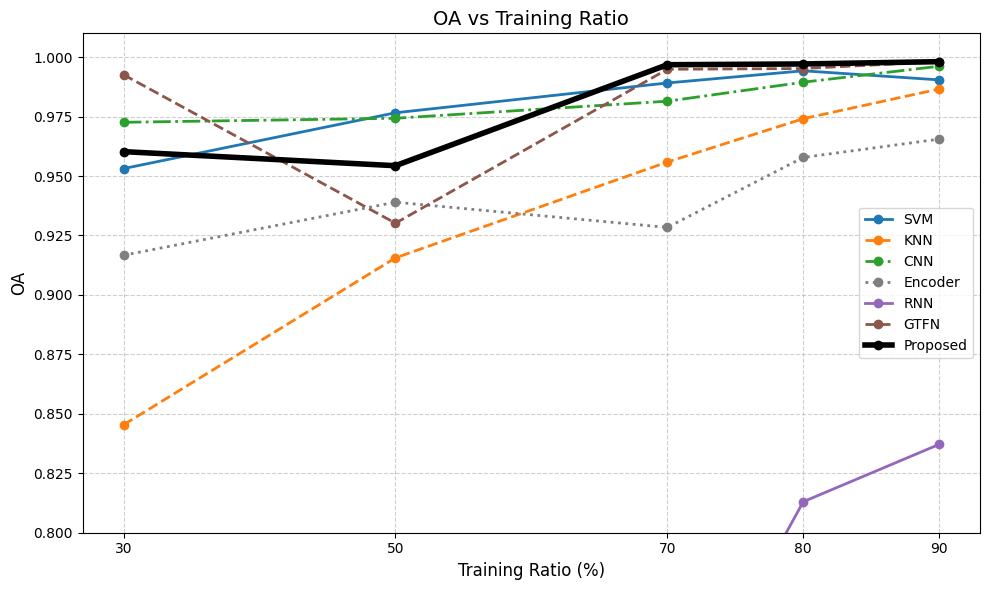

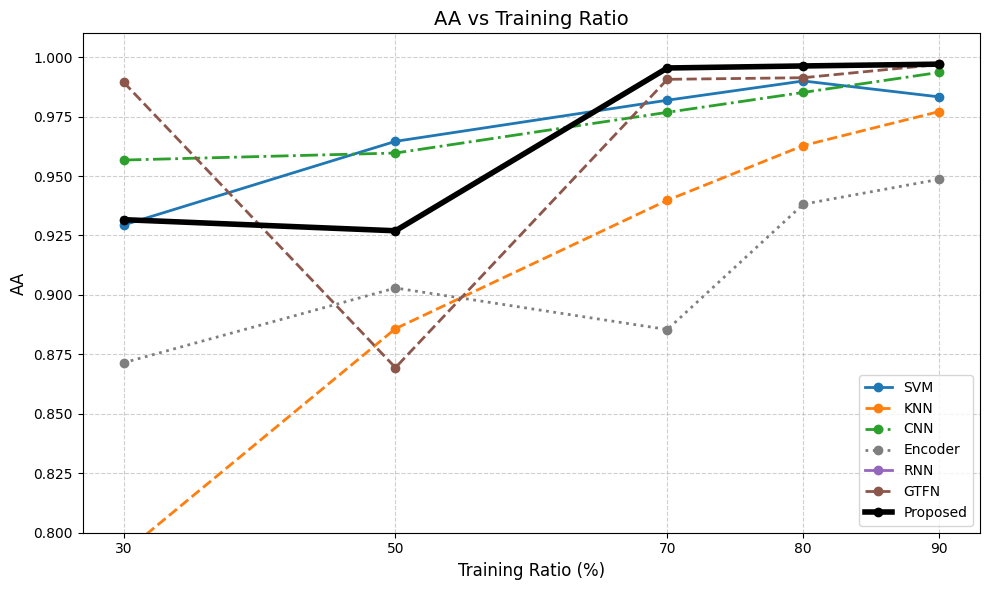

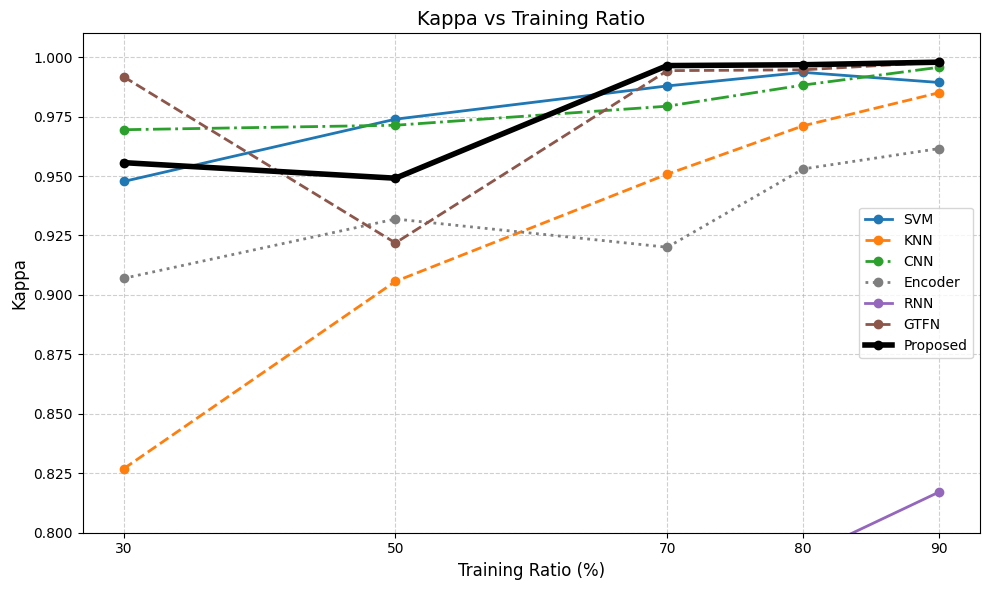

In [ ]:
import matplotlib.pyplot as plt

# Training ratios used
train_ratios = [0.3, 0.5, 0.7, 0.8, 0.9]
train_ratio_percent = [int(r * 100) for r in train_ratios]
import matplotlib.pyplot as plt

metrics = ['OA', 'AA', 'Kappa']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray', 'tab:purple', 'tab:brown']
linestyles = ['-', '--', '-.', ':', '-', '--']
highlight_color = 'black'
highlight_linestyle = '-'
highlight_linewidth = 4

model_names = ['SVM', 'KNN', 'CNN', 'Encoder', 'RNN', 'GTFN', 'Proposed']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    for idx, model in enumerate(model_names):
        if metric in results_by_ratio[model]:
            if model == 'Proposed':
                plt.plot(
                    train_ratio_percent,
                    results_by_ratio[model][metric],
                    label=model,
                    marker='o',
                    color=highlight_color,
                    linestyle=highlight_linestyle,
                    linewidth=highlight_linewidth,
                    zorder=10  # keep it on top
                )
            else:
                plt.plot(
                    train_ratio_percent,
                    results_by_ratio[model][metric],
                    label=model,
                    marker='o',
                    color=colors[idx % len(colors)],
                    linestyle=linestyles[idx % len(linestyles)],
                    linewidth=2
                )
    plt.title(f'{metric} vs Training Ratio', fontsize=14)
    plt.xlabel('Training Ratio (%)', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(train_ratio_percent)
    plt.ylim(0.8, 1.01)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

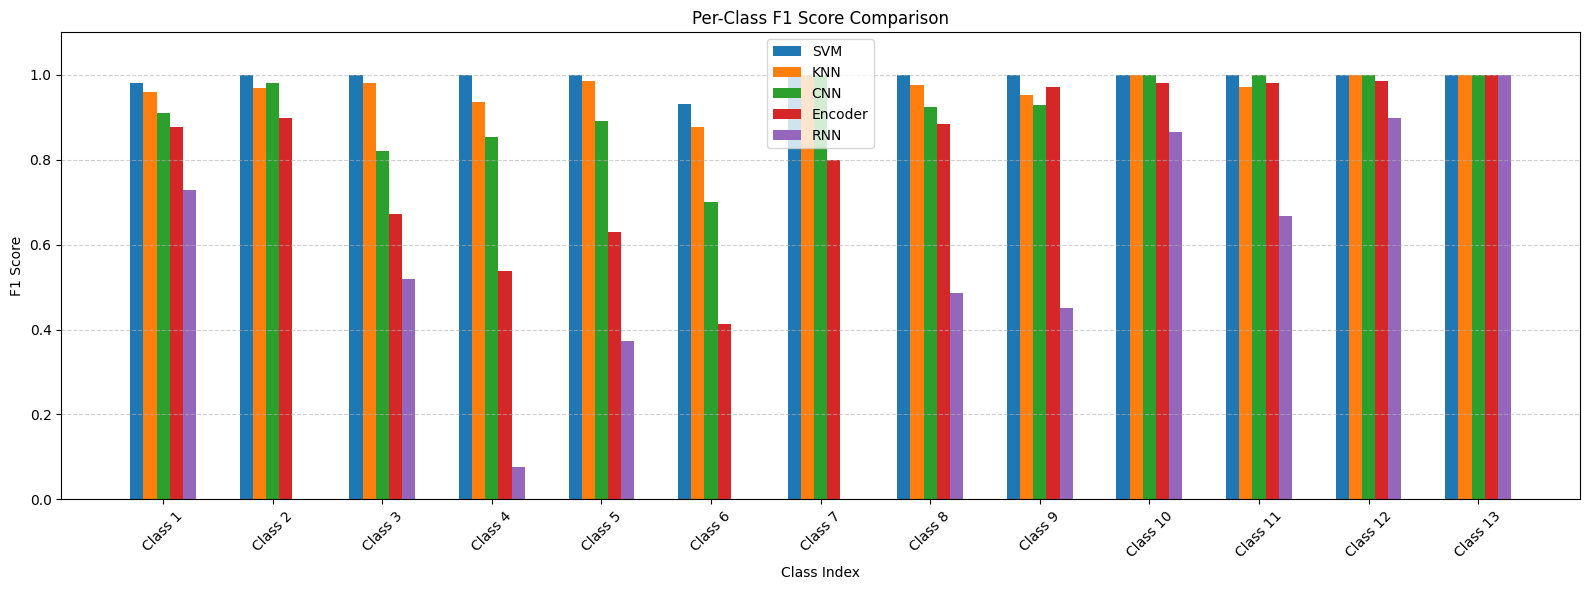

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
num_models = len(model_names)
f1_per_class = [results[model]["F1"] for model in model_names]

x = np.arange(len(f1_per_class[0]))  # class indices
bar_width = 0.12

plt.figure(figsize=(16, 6))
for i, f1 in enumerate(f1_per_class):
    plt.bar(x + i * bar_width, f1, width=bar_width, label=model_names[i])

plt.xlabel("Class Index")
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Score Comparison")
plt.xticks(x + (num_models / 2 - 0.5) * bar_width, [f"Class {i+1}" for i in x], rotation=45)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

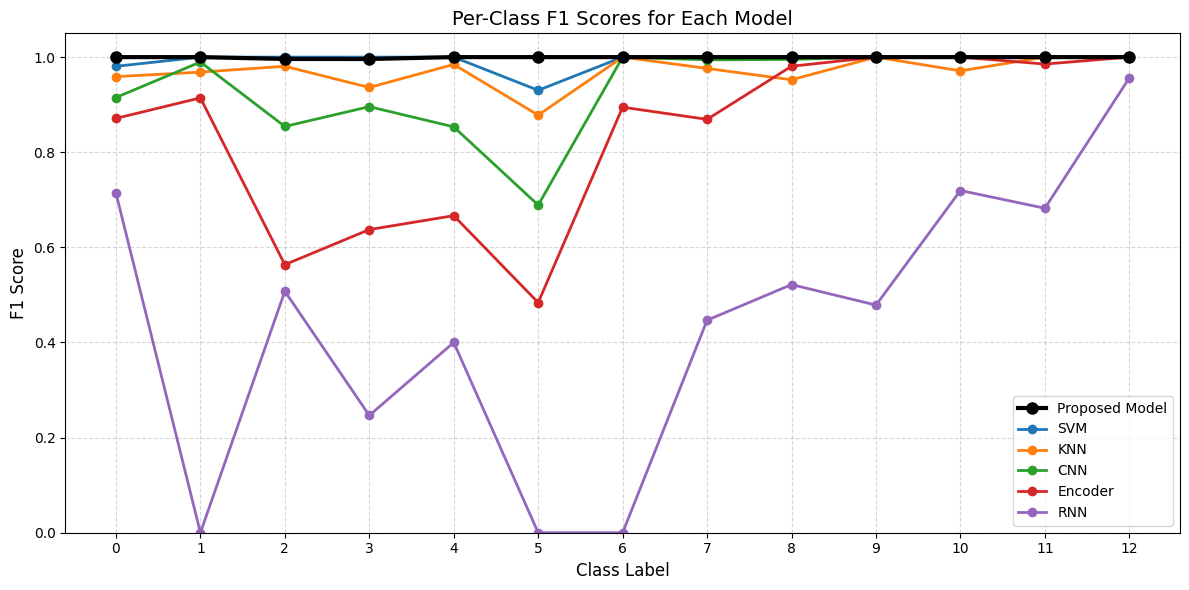

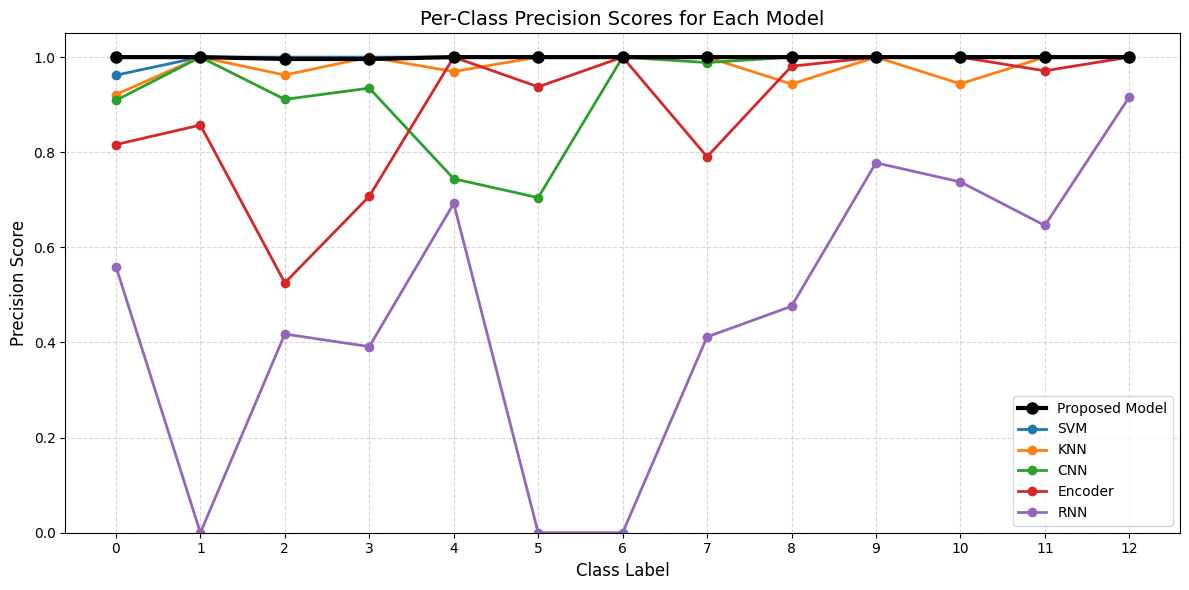

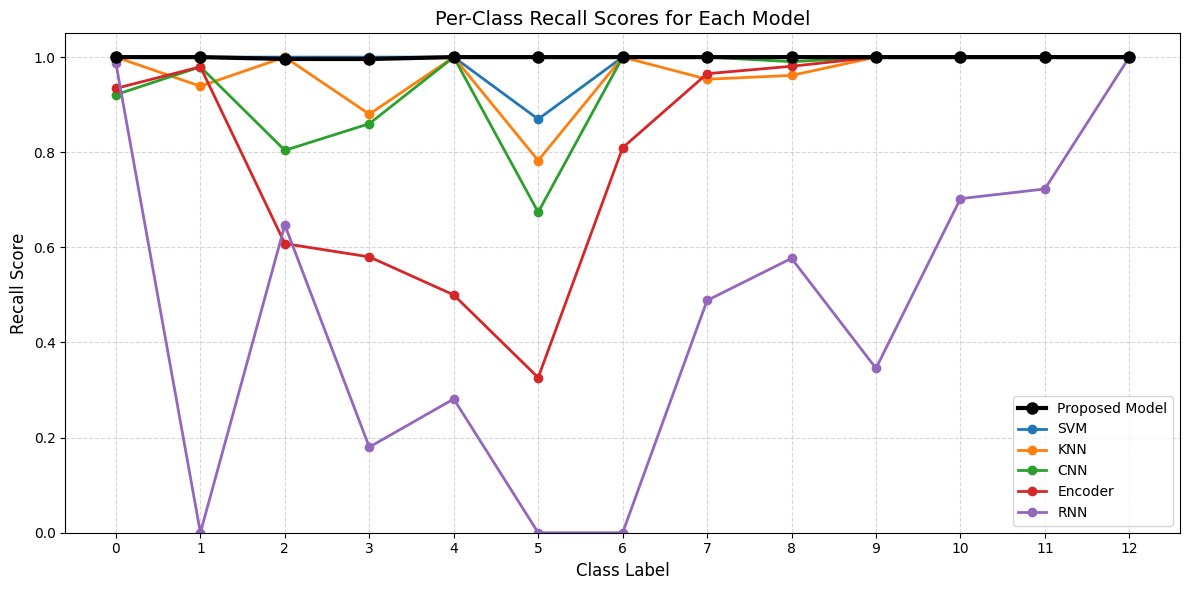

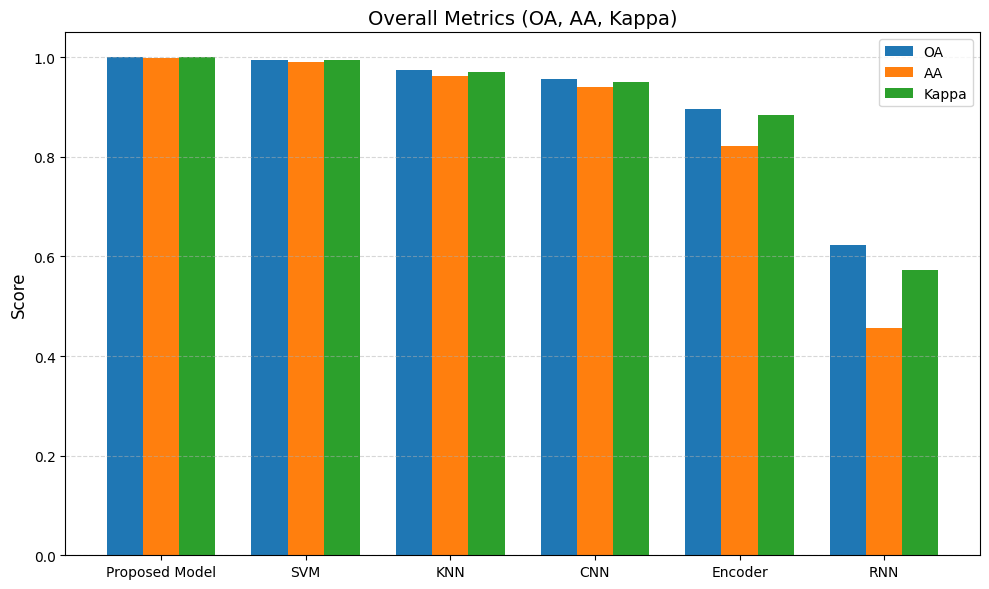

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
num_classes = len(results[models[0]]['F1'])
classes = list(range(num_classes))
metrics = ['F1', 'Precision', 'Recall']

# Line Plot: Per-class metric scores
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for model in models:
        if model == "Proposed Model":
            plt.plot(
                classes,
                results[model][metric],
                marker='o',
                label=model,
                color='black',
                linewidth=3,
                markersize=8,
                zorder=10
            )
        else:
            plt.plot(
                classes,
                results[model][metric],
                marker='o',
                label=model,
                linewidth=2
            )

    plt.title(f'Per-Class {metric} Scores for Each Model', fontsize=14)
    plt.xlabel('Class Label', fontsize=12)
    plt.ylabel(f'{metric} Score', fontsize=12)
    plt.xticks(classes)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Bar Plot: OA, AA, Kappa comparison
oa_vals = [results[m]['OA'] for m in models]
aa_vals = [float(results[m]['AA']) for m in models]
kappa_vals = [float(results[m]['Kappa']) for m in models]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width, oa_vals, width, label='OA')
bars2 = plt.bar(x, aa_vals, width, label='AA')
bars3 = plt.bar(x + width, kappa_vals, width, label='Kappa')

# Highlight Proposed model in bar chart
for i, model in enumerate(models):
    if model == "Proposed":
        for bars in [bars1, bars2, bars3]:
            bars[i].set_color('black')
            bars[i].set_edgecolor('red')
            bars[i].set_linewidth(2)

plt.xticks(x, models)
plt.ylabel('Score', fontsize=12)
plt.title('Overall Metrics (OA, AA, Kappa)', fontsize=14)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


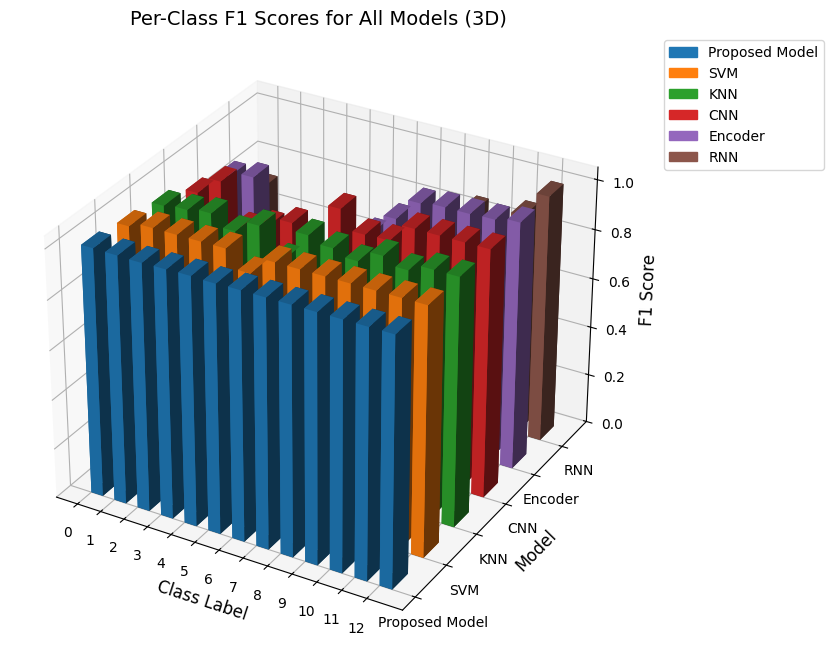

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

models = list(results.keys())
classes = list(range(len(results[models[0]]['F1'])))
num_models = len(models)
num_classes = len(classes)

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(num_classes)
_y = np.arange(num_models)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# Flatten F1 scores
dz = []
for model in models:
    dz.extend(results[model]['F1'])
dz = np.array(dz)

# Bar position and size
z = np.zeros_like(x)
dx = dy = 0.5

# Assign distinct colors per model using tab10
model_colors = plt.get_cmap('tab10')
colors = [model_colors(i % 10) for i in y]  # same color for same model

# Plot 3D bar chart
ax.bar3d(x, y, z, dx, dy, dz, color=colors, shade=True)

# Axis labels
ax.set_xlabel('Class Label', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_zlabel('F1 Score', fontsize=12)
ax.set_title('Per-Class F1 Scores for All Models (3D)', fontsize=14)

# Ticks and labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_models))
ax.set_yticklabels(models)
ax.set_zlim(0, 1.05)

# Add legend manually
from matplotlib.patches import Patch
legend_patches = [Patch(color=model_colors(i % 10), label=models[i]) for i in range(num_models)]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [ ]:
results_by_ratio.keys()

dict_keys(['SVM', 'KNN', 'CNN', 'Encoder', 'RNN', 'GTFN', 'Proposed'])

Error getting features for proposed: No such layer: your_last_feature_layer_name. Existing layers are: ['input_layer', 'conv2d_4', 'conv2d_5', 'max_pooling2d', 'conv2d_6', 'conv2d_7', 'up_sampling2d', 'resizing', 'conv2d', 'conv2d_1', 'concatenate', 'multiply', 'conv2d_8', 'conv2d_10', 'conv2d_11', 'conv2d_2', 'conv2d_3', 'conv2d_9', 'multiply_2', 'multiply_1', 'add', 'add_1', 'global_average_pooling2d', 'input_layer_1', 'dense_1'].


KeyboardInterrupt: 

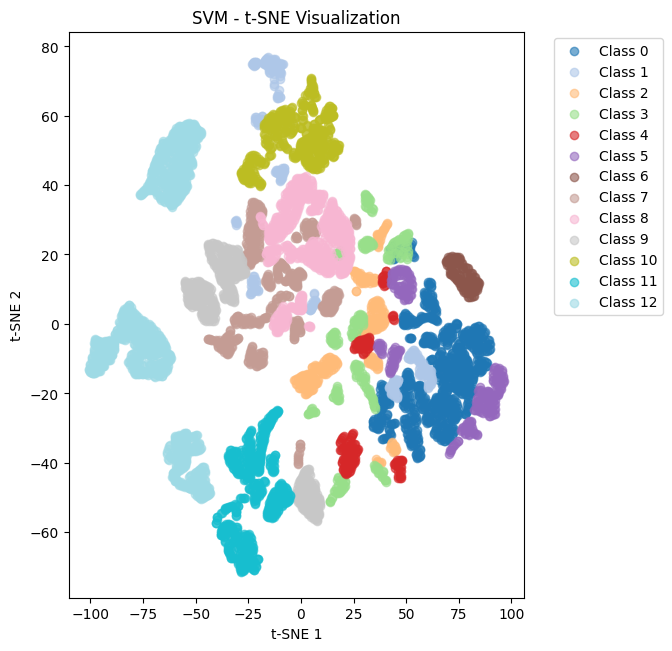

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Prepare the data - using only test split for clarity
X_test_patch = X_patches  # Using all data for visualization
X_test_flat = X_patches.reshape(X_patches.shape[0], -1)
X_test_seq = X_patches.reshape(X_patches.shape[0], -1, X_patches.shape[-1])

# Get features from all models
def get_features(model, X_data, model_type):
    try:
        if model_type in ['svm', 'knn']:
            # For SVM/KNN, we'll use PCA-reduced raw features
            pca = PCA(n_components=50)
            return pca.fit_transform(X_data.reshape(X_data.shape[0], -1))
        elif model_type == 'proposed':
            # Correct feature extraction for your proposed model
            feature_model = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.get_layer('your_last_feature_layer_name').output
            )
            features = feature_model.predict(
                [X_data, np.ones((X_data.shape[0], 1))],
                verbose=0,
                batch_size=32
            )
            return features.reshape(features.shape[0], -1)  # Flatten if needed
        elif model_type in ['cnn', 'cnn_encoder', 'gtfn']:
            feature_model = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.layers[-2].output
            )
            return feature_model.predict(X_data, verbose=0)
        elif model_type == 'rnn':
            feature_model = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.layers[-2].output
            )
            return feature_model.predict(X_data, verbose=0)
    except Exception as e:
        print(f"Error getting features for {model_type}: {str(e)}")
        return None

# Get features from each model
features = {
    'SVM': get_features(svm, X_test_flat, 'svm'),
    'KNN': get_features(knn, X_test_flat, 'knn'),
    'CNN': get_features(cnn, X_test_patch, 'cnn'),
    'CNN Encoder': get_features(cnn_encoder, X_test_patch, 'cnn_encoder'),
    'RNN': get_features(rnn, X_test_seq, 'rnn'),
    'GTFN': get_features(gtfn_model, X_test_patch, 'gtfn'),
    'Proposed': get_features(proposed, X_test_patch, 'proposed')
}

# Filter out None results
features = {k: v for k, v in features.items() if v is not None}

# Create t-SNE plots
plt.figure(figsize=(20, 25))
n_rows = 3
n_cols = 3

# Use consistent colors for classes
unique_classes = np.unique(y_labels)
colors = plt.cm.get_cmap('tab20', len(unique_classes))

for idx, (model_name, feats) in enumerate(features.items(), 1):
    try:
        # First reduce with PCA if needed
        if feats.shape[1] > 50:
            pca = PCA(n_components=50)
            feats = pca.fit_transform(feats)

        # Then apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        tsne_results = tsne.fit_transform(feats)

        plt.subplot(n_rows, n_cols, idx)
        for cls in unique_classes:
            mask = (y_labels == cls)
            plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                        color=colors(cls), label=f'Class {cls}', alpha=0.6)

        plt.title(f'{model_name} - t-SNE Visualization')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        if idx == 1:  # Only show legend for first plot
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    except Exception as e:
        print(f"Error creating t-SNE for {model_name}: {str(e)}")
        continue

# Add ground truth plot (using raw features with PCA)
try:
    pca = PCA(n_components=50)
    X_reduced = pca.fit_transform(X_test_flat)
    tsne_raw = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_raw_results = tsne_raw.fit_transform(X_reduced)

    plt.subplot(n_rows, n_cols, len(features)+1)
    for cls in unique_classes:
        mask = (y_labels == cls)
        plt.scatter(tsne_raw_results[mask, 0], tsne_raw_results[mask, 1],
                    color=colors(cls), label=f'Class {cls}', alpha=0.6)
    plt.title('Raw Features (PCA) - t-SNE Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
except Exception as e:
    print(f"Error creating raw features t-SNE: {str(e)}")

plt.tight_layout()
plt.show()

In [44]:
features

{'SVM': array([[-0.12409087, -1.10041077,  1.57344644, ..., -0.68189206,
          0.22525006,  0.12073947],
        [-0.43861322, -1.74886329, -0.04584256, ..., -0.44074125,
          0.11880445, -0.24619752],
        [-0.81100161, -2.50396536, -1.58395916, ...,  0.31543574,
         -0.27192506,  0.1174827 ],
        ...,
        [-3.81689314, -2.17203695,  0.29238121, ..., -0.11756158,
         -0.08598769,  0.09721852],
        [-3.84843921, -2.04097235,  0.32215403, ...,  0.0226149 ,
         -0.10792378, -0.01626589],
        [-3.99373727, -1.82664109,  0.44117588, ...,  0.21567947,
         -0.03833676, -0.12546479]]),
 'KNN': array([[-1.24090871e-01, -1.10041077e+00,  1.57344644e+00, ...,
         -6.74190962e-01,  2.60428743e-01,  1.13248225e-01],
        [-4.38613216e-01, -1.74886329e+00, -4.58425573e-02, ...,
         -4.36804085e-01,  1.06744135e-01, -2.58034686e-01],
        [-8.11001612e-01, -2.50396536e+00, -1.58395916e+00, ...,
          2.89388336e-01, -2.91073180e-01,

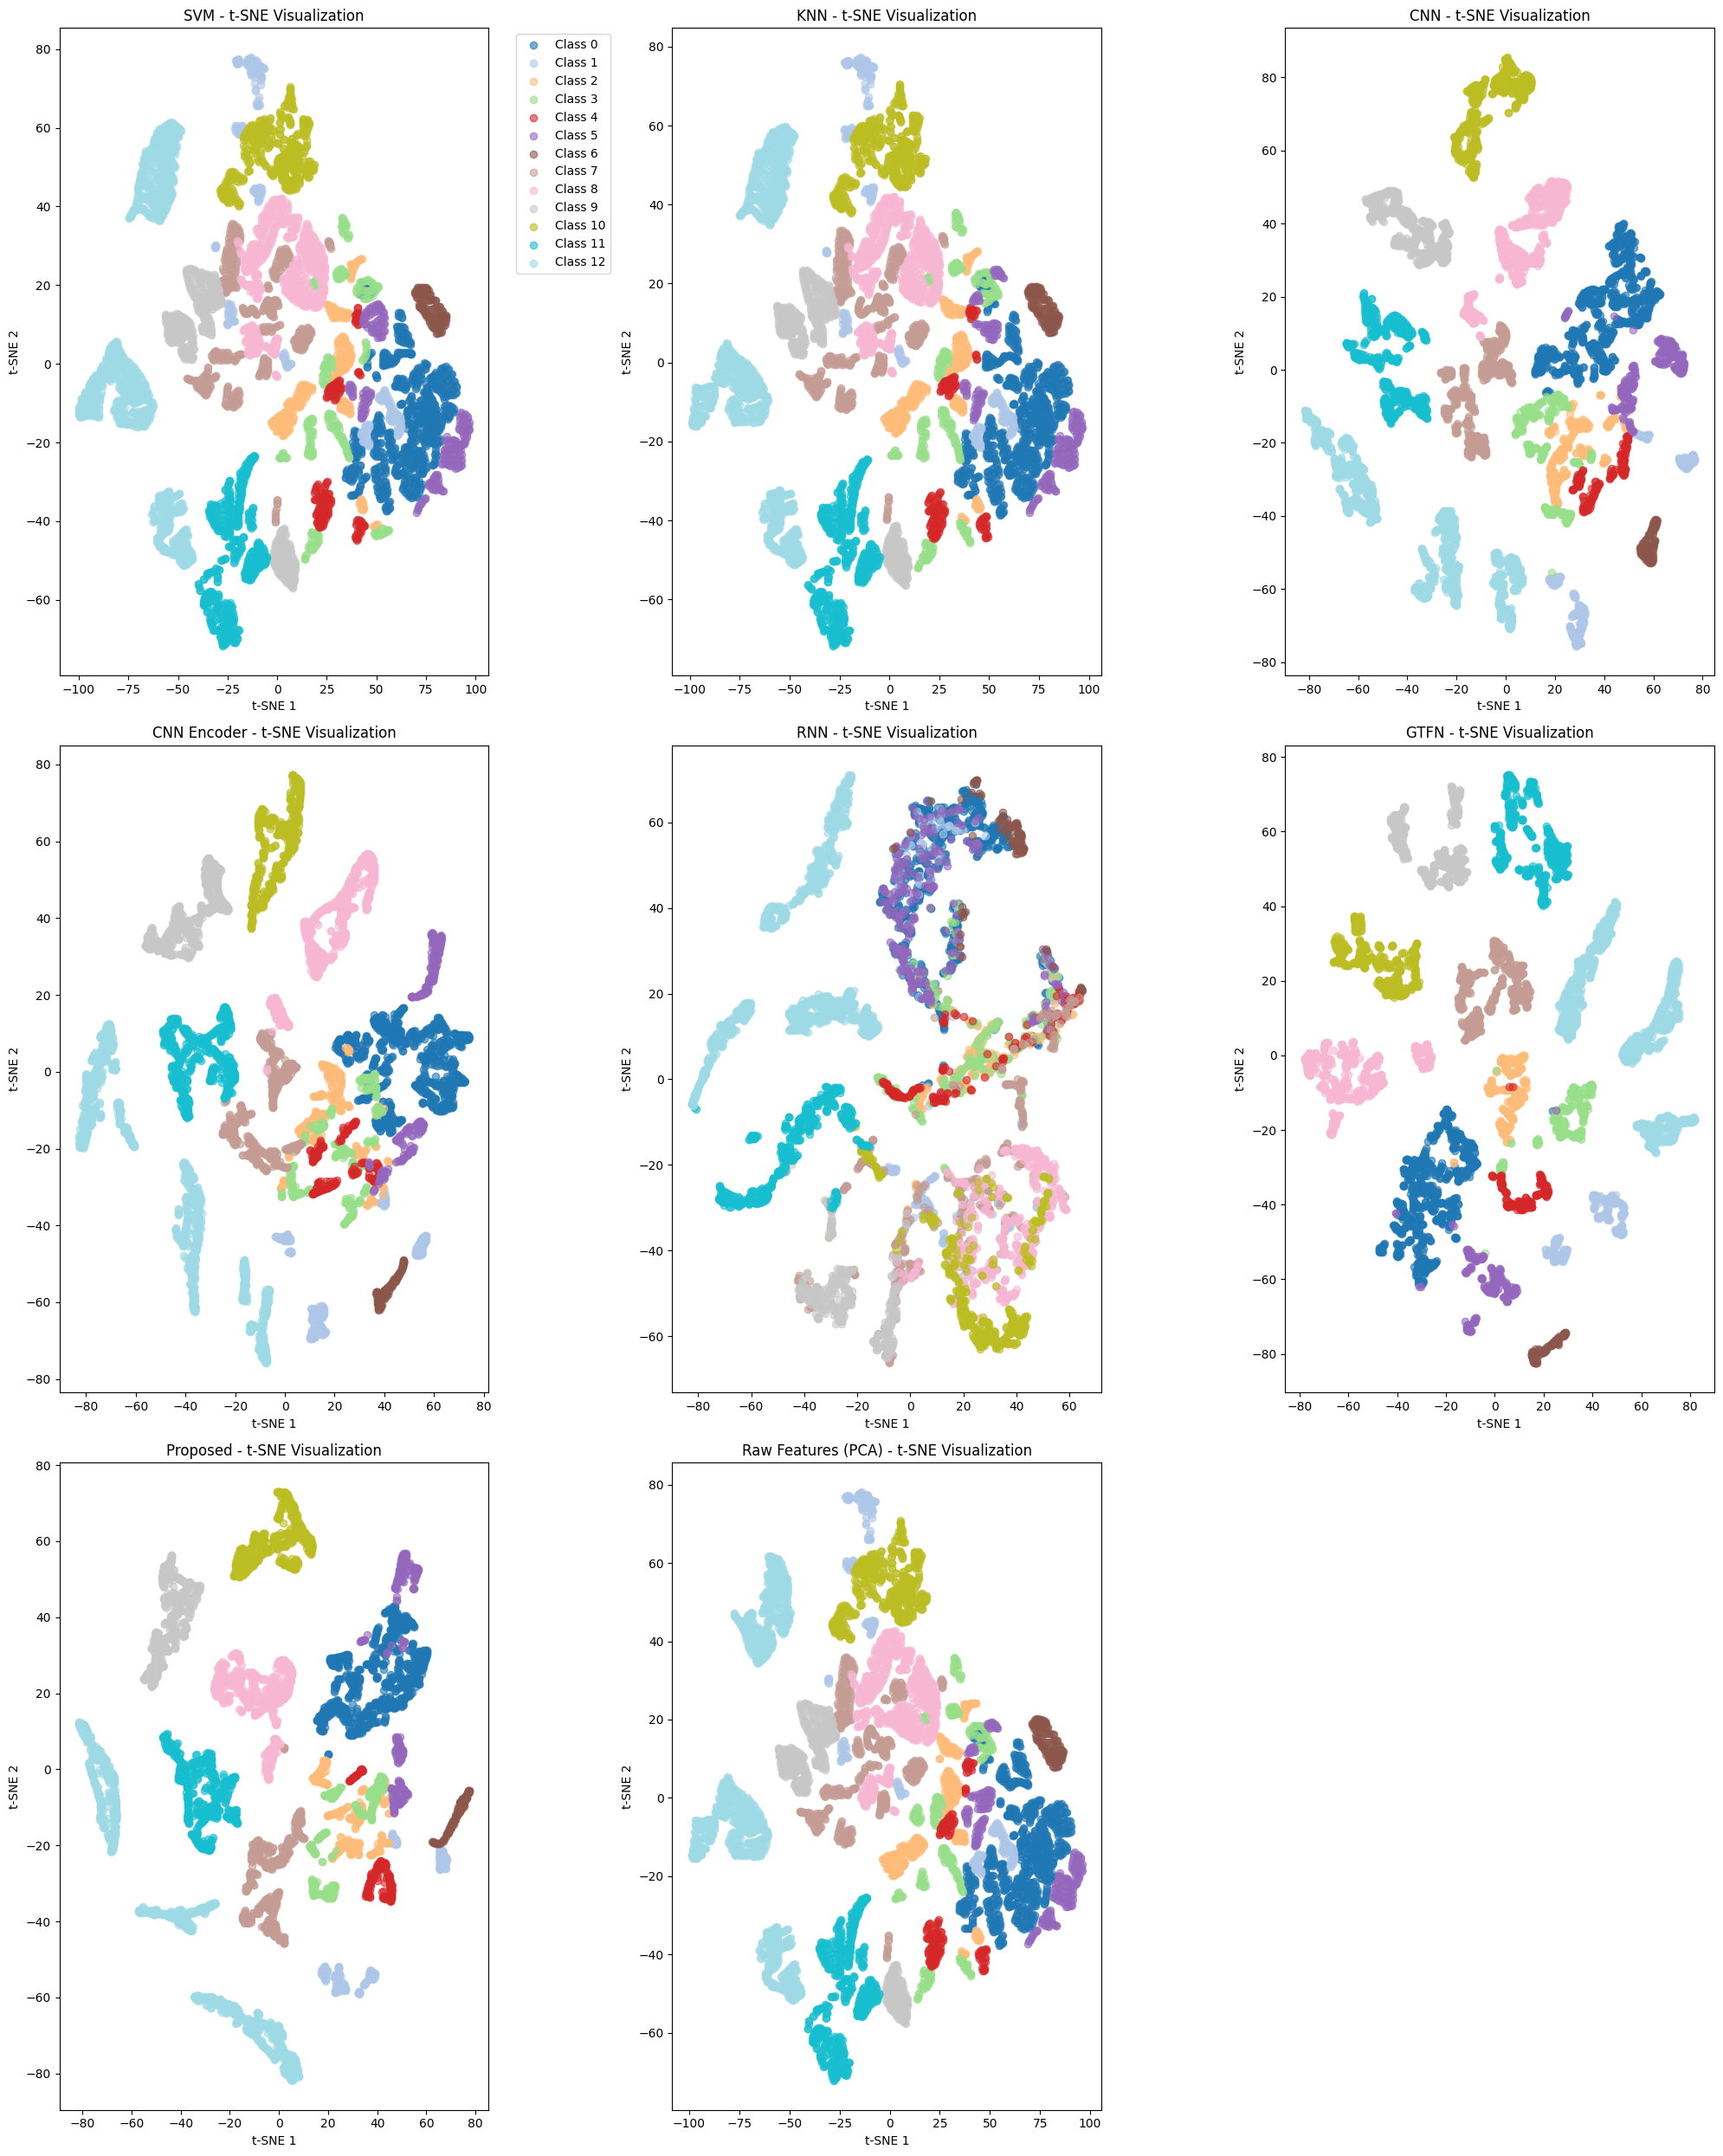

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Prepare the data
X_test_patch = X_patches  # Using all data for visualization
X_test_flat = X_patches.reshape(X_patches.shape[0], -1)
X_test_seq = X_patches.reshape(X_patches.shape[0], -1, X_patches.shape[-1])

# Get features from all models
def get_features(model, X_data, model_type):
    try:
        if model_type in ['svm', 'knn']:
            # For SVM/KNN, we'll use PCA-reduced raw features
            pca = PCA(n_components=50)
            return pca.fit_transform(X_data.reshape(X_data.shape[0], -1))
        elif model_type == 'proposed':
            # Correct feature extraction for your proposed model
            feature_model = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.get_layer('global_average_pooling2d').output
            )
            features = feature_model.predict(
                [X_data, np.ones((X_data.shape[0], 1))],
                verbose=0,
                batch_size=32
            )
            return features
        elif model_type in ['cnn', 'cnn_encoder', 'gtfn']:
            feature_model = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.layers[-2].output
            )
            return feature_model.predict(X_data, verbose=0)
        elif model_type == 'rnn':
            feature_model = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.layers[-2].output
            )
            return feature_model.predict(X_data, verbose=0)
    except Exception as e:
        print(f"Error getting features for {model_type}: {str(e)}")
        return None

# Get features from each model
features = {
    'SVM': get_features(svm, X_test_flat, 'svm'),
    'KNN': get_features(knn, X_test_flat, 'knn'),
    'CNN': get_features(cnn, X_test_patch, 'cnn'),
    'CNN Encoder': get_features(cnn_encoder, X_test_patch, 'cnn_encoder'),
    'RNN': get_features(rnn, X_test_seq, 'rnn'),
    'GTFN': get_features(gtfn_model, X_test_patch, 'gtfn'),
    'Proposed': get_features(proposed, X_test_patch, 'proposed')
}

# Filter out None results
features = {k: v for k, v in features.items() if v is not None}

# Create t-SNE plots
plt.figure(figsize=(20, 25))
n_rows = 3
n_cols = 3

# Use consistent colors for classes
unique_classes = np.unique(y_labels)
colors = plt.cm.get_cmap('tab20', len(unique_classes))

for idx, (model_name, feats) in enumerate(features.items(), 1):
    try:
        # First reduce with PCA if needed
        if feats.shape[1] > 50:
            pca = PCA(n_components=50)
            feats = pca.fit_transform(feats)

        # Then apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        tsne_results = tsne.fit_transform(feats)

        plt.subplot(n_rows, n_cols, idx)
        for cls in unique_classes:
            mask = (y_labels == cls)
            plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                        color=colors(cls), label=f'Class {cls}', alpha=0.6)

        plt.title(f'{model_name} - t-SNE Visualization')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        if idx == 1:  # Only show legend for first plot
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    except Exception as e:
        print(f"Error creating t-SNE for {model_name}: {str(e)}")
        continue

# Add ground truth plot (using raw features with PCA)
try:
    pca = PCA(n_components=50)
    X_reduced = pca.fit_transform(X_test_flat)
    tsne_raw = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_raw_results = tsne_raw.fit_transform(X_reduced)

    plt.subplot(n_rows, n_cols, len(features)+1)
    for cls in unique_classes:
        mask = (y_labels == cls)
        plt.scatter(tsne_raw_results[mask, 0], tsne_raw_results[mask, 1],
                    color=colors(cls), label=f'Class {cls}', alpha=0.6)
    plt.title('Raw Features (PCA) - t-SNE Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
except Exception as e:
    print(f"Error creating raw features t-SNE: {str(e)}")

plt.tight_layout()
plt.show()

ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

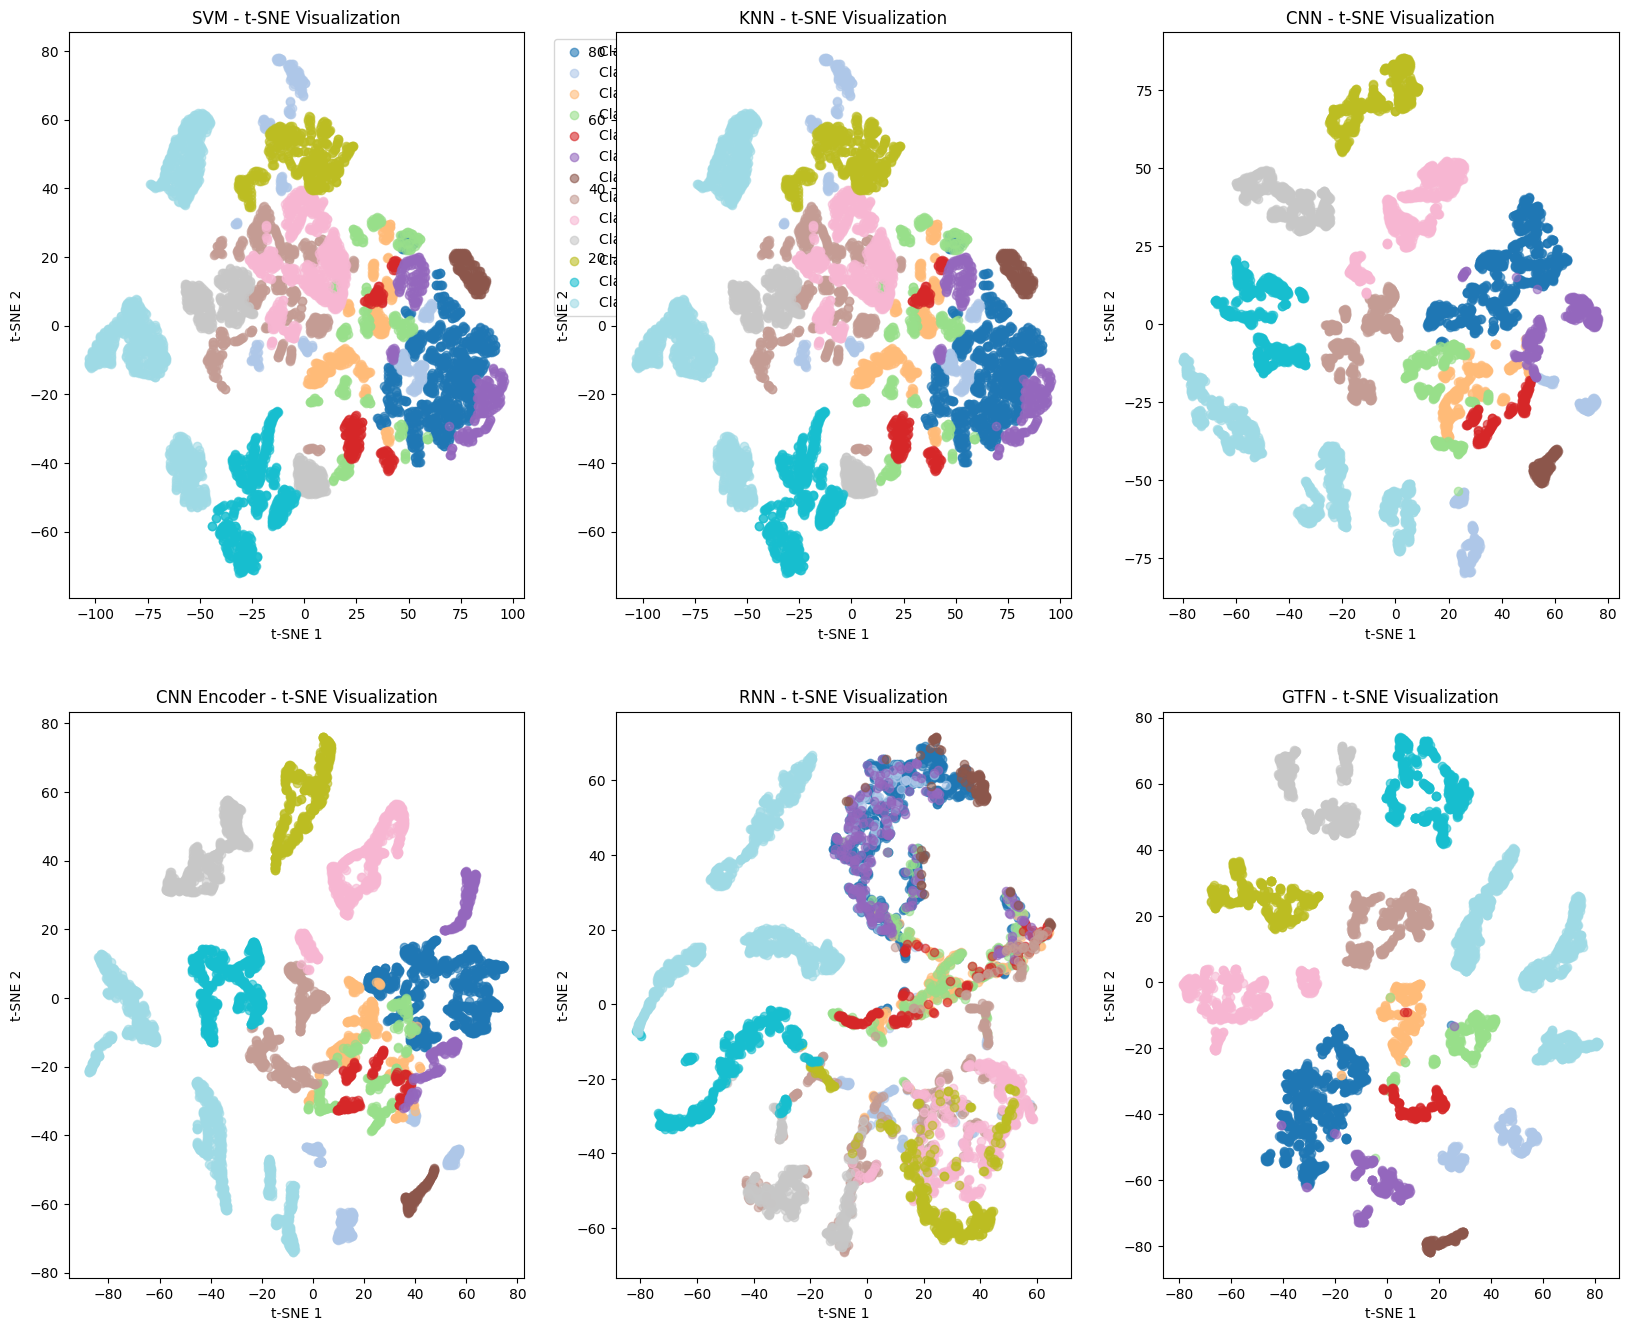

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
X_test_patch = X_patches  # Using all data for visualization
X_test_flat = X_patches.reshape(X_patches.shape[0], -1)
X_test_seq = X_patches.reshape(X_patches.shape[0], -1, X_patches.shape[-1])

# Get features from all models
def get_features(model, X_data, model_type):
    if model_type in ['svm', 'knn']:
        return X_data  # For SVM/KNN, we use the raw features
    elif model_type == 'proposed':
        feature_model = tf.keras.Model(inputs=model.inputs,
                                     outputs=model.layers[-2].output)
        return feature_model.predict([X_data, np.ones((X_data.shape[0], 1))], verbose=0)
    elif model_type in ['cnn', 'cnn_encoder', 'gtfn']:
        feature_model = tf.keras.Model(inputs=model.inputs,
                                     outputs=model.layers[-2].output)
        return feature_model.predict(X_data, verbose=0)
    elif model_type == 'rnn':
        feature_model = tf.keras.Model(inputs=model.inputs,
                                     outputs=model.layers[-2].output)
        return feature_model.predict(X_data, verbose=0)

# Get features from each model
features = {
    'SVM': X_test_flat,
    'KNN': X_test_flat,
    'CNN': get_features(cnn, X_test_patch, 'cnn'),
    'CNN Encoder': get_features(cnn_encoder, X_test_patch, 'cnn_encoder'),
    'RNN': get_features(rnn, X_test_seq, 'rnn'),
    'GTFN': get_features(gtfn_model, X_test_patch, 'gtfn'),
    'Proposed': get_features(proposed, X_test_patch, 'proposed')
}

# Create t-SNE plots
plt.figure(figsize=(20, 25))
n_rows = 3
n_cols = 3

# Use consistent colors for classes
unique_classes = np.unique(y_labels)
colors = plt.cm.get_cmap('tab20', len(unique_classes))

for idx, (model_name, feats) in enumerate(features.items(), 1):
    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(feats)

    plt.subplot(n_rows, n_cols, idx)
    for cls in unique_classes:
        mask = (y_labels == cls)
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                    color=colors(cls), label=f'Class {cls}', alpha=0.6)

    plt.title(f'{model_name} - t-SNE Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    if idx == 1:  # Only show legend for first plot to save space
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add ground truth plot (using raw features)
tsne_raw = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_raw_results = tsne_raw.fit_transform(X_test_flat)

plt.subplot(n_rows, n_cols, len(features)+1)
for cls in unique_classes:
    mask = (y_labels == cls)
    plt.scatter(tsne_raw_results[mask, 0], tsne_raw_results[mask, 1],
                color=colors(cls), label=f'Class {cls}', alpha=0.6)
plt.title('Raw Features - t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Define a colormap: 16-class example (you can customize as needed)
num_classes = np.max(gt)
cmap = plt.get_cmap('tab20', num_classes)
norm = colors.BoundaryNorm(boundaries=np.arange(num_classes+1)-0.5, ncolors=num_classes)

# Function to plot maps side-by-side
import matplotlib.pyplot as plt

def plot_prediction_maps(gt, pred_maps, models, cmap, norm, title_prefix=""):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(4 * (n_models + 1), 4))

    # Ground truth
    axes[0].imshow(gt, cmap=cmap, norm=norm)
    axes[0].set_title("Ground Truth", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Each model's prediction
    for i, model in enumerate(models):
        axes[i + 1].imshow(pred_maps[model], cmap=cmap, norm=norm)
        if model == "Proposed":
            axes[i + 1].set_title(f"{model} Prediction", fontsize=14, color='red', fontweight='bold')
        else:
            axes[i + 1].set_title(f"{model} Prediction", fontsize=14)
        axes[i + 1].axis('off')

    plt.suptitle(f"{title_prefix} Classification Maps", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
pred_map_dict = {
    "SVM": y_pred_svm,
    "KNN": y_pred_knn,
    "CNN": y_pred_cnn,
    "Encoder": y_pred_encoder,
    "RNN": y_pred_rnn,
    "GTFN": y_pred_gtfn,
    "Proposed": y_pred
}

In [ ]:
print(y_pred_svm.shape)
print(y_pred_knn.shape)
print(y_pred_cnn.shape)
print(y_pred_encoder.shape)
print(y_pred_rnn.shape)
print(y_pred_gtfn.shape)
print(y_pred.shape)

(1043,)
(1043,)
(1043,)
(1043,)
(1043,)
(1043,)
(522,)


In [ ]:
model_names = ['SVM', 'KNN', 'CNN', 'Encoder', 'RNN', 'GTFN', 'Proposed']

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Flatten label map
y_labels = gt.flatten()
n_pixels = y_labels.shape[0]
height, width = gt.shape

# Step 2: Get full indices
all_indices = np.arange(n_pixels)
valid_mask = y_labels != 0  # ignore background
valid_indices = np.where(valid_mask)[0]  # only non-zero class pixels

train_idx, test_idx = train_test_split(
    valid_indices, train_size=ratio, stratify=y_labels[valid_mask], random_state=42
)
# Step 4: Function to reconstruct full-sized maps
def reconstruct_map(y_pred_flat, test_idx, height, width):
    full_map = np.zeros((height * width,), dtype=np.uint8)
    full_map[test_idx[:len(y_pred_flat)]] = y_pred_flat
    return full_map.reshape((height, width))

In [ ]:

# Train/test split with indices
indices = np.arange(len(y_labels))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y_labels, random_state=42)


In [ ]:
def create_prediction_map(y_pred, test_idx, gt_shape):
    """
    Create full prediction map from patch predictions.
    y_pred: (N_test,) - model predictions
    test_idx: (N_total_test_pixels,) - flattened test pixel indices
    gt_shape: shape of original image (height, width)
    """
    full_map = np.zeros(gt_shape[0] * gt_shape[1], dtype=np.uint8)
    full_map[test_idx[:len(y_pred)]] = y_pred  # Only fill what you have
    return full_map.reshape(gt_shape)


In [ ]:
pred_map_dict = {
    "SVM": create_prediction_map(y_pred_svm, test_idx, gt.shape),
    "KNN": create_prediction_map(y_pred_knn, test_idx, gt.shape),
    "CNN": create_prediction_map(y_pred_cnn, test_idx, gt.shape),
    "Encoder": create_prediction_map(y_pred_encoder, test_idx, gt.shape),
    "RNN": create_prediction_map(y_pred_rnn, test_idx, gt.shape),
    "GTFN": create_prediction_map(y_pred_gtfn, test_idx, gt.shape),
    "Proposed": create_prediction_map(y_pred, test_idx, gt.shape)
}


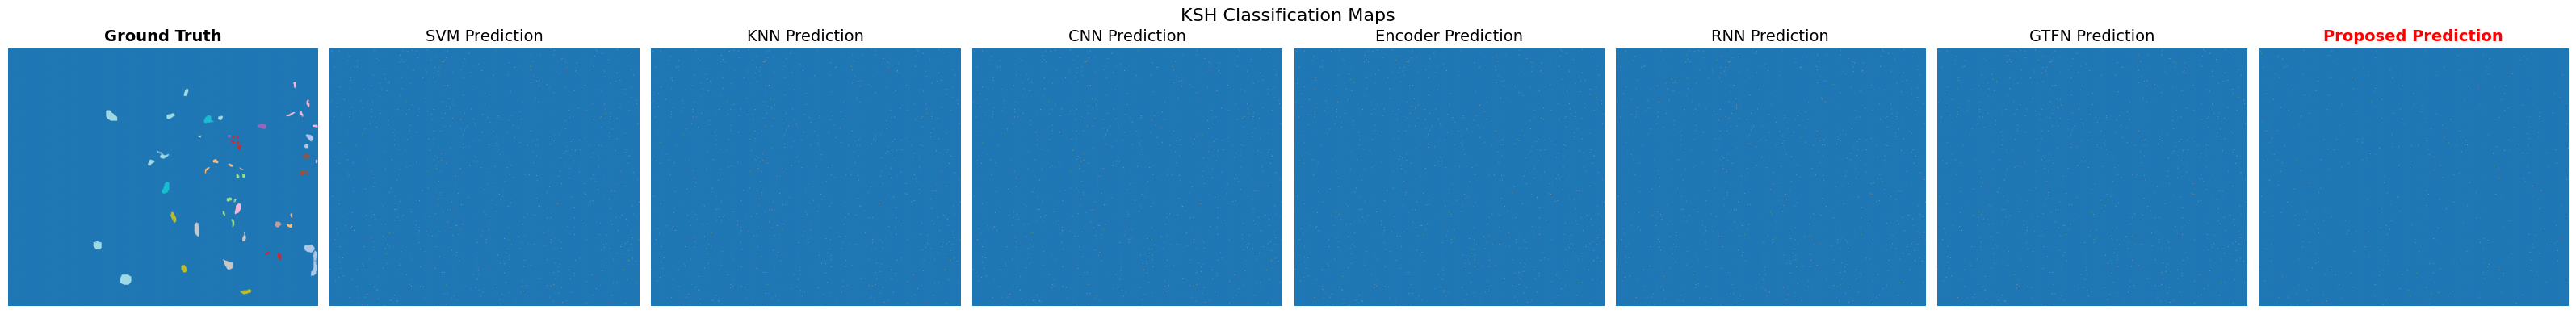

In [ ]:
plot_prediction_maps(
    gt=gt,
    pred_maps=pred_map_dict,
    models=["SVM", "KNN", "CNN", "Encoder", "RNN", "GTFN", "Proposed"],
    cmap=cmap,
    norm=norm,
    title_prefix="KSH"
)


In [ ]:
test_idx.shape

(62874,)

In [ ]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
def generate_prediction_map(y_pred, test_idx, full_shape):
    # Initialize all pixels to 0 (or -1 if you want to mask unclassified)
    full_pred = np.zeros(full_shape, dtype=np.uint8)

    # Map test predictions to their correct spatial positions
    full_pred[test_idx] = y_pred

    return full_pred

In [ ]:
# Step 5: Reconstruct prediction maps
pred_map_dict = {
    "SVM": reconstruct_map(y_pred_svm, test_idx, height, width),
    "KNN": reconstruct_map(y_pred_knn, test_idx, height, width),
    "CNN": reconstruct_map(y_pred_cnn, test_idx, height, width),
    "Encoder": reconstruct_map(y_pred_encoder, test_idx, height, width),
    "RNN": reconstruct_map(y_pred_rnn, test_idx, height, width),
    "GTFN": reconstruct_map(y_pred_gtfn, test_idx, height, width),
    "Proposed": reconstruct_map(y_pred, test_idx, height, width)  # handles 522 samples too
}

ValueError: shape mismatch: value array of shape (1043,) could not be broadcast to indexing result of shape (522,)

In [ ]:
def generate_full_prediction_map(test_idx, y_pred, total_pixels, fill_value=0):
    full_pred = np.full((total_pixels,), fill_value)  # default to 0 or background
    full_pred[test_idx] = y_pred
    return full_pred